# Collection of modules for image analysis
### March 13,2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

import subprocess as sp
import os
import glob

from scipy import fftpack

In [2]:
def f_plot_grid(arr,cols=16):
    
    size=arr.shape[0]
    assert cols<=size, "cols %s greater than array size %s"%(cols,size)
    
    rows=int(size/cols)+1
    
    fig,axarr=plt.subplots(rows,cols,figsize=(16,16),constrained_layout=True)
    for i in range(rows*cols):
        row,col=int(i/cols),i%cols
#         print(i,'\t',row,col)
        try: 
            axarr[row,col].imshow(arr[i])
    #         axarr[row,col].imshow(arr[i],origin='lower',interpolation='nearest',cmap='cool', extent = [0, 128, 0, 128])
    #         fig.subplots_adjust(left=0.01,bottom=0.01,right=0.1,top=0.1,wspace=0.001,hspace=0.0001)
    #         fig.tight_layout()
        # Drop axis label
        except: 
            pass
        temp=plt.setp([a.get_xticklabels() for a in axarr[:-1,:].flatten()], visible=False)
        temp=plt.setp([a.get_yticklabels() for a in axarr[:,1:].flatten()], visible=False)


def f_pixel_intensity(img_arr,normalize=True,plot=True):
    '''
    Module to compute and plot histogram for pixel intensity of images
    '''
    
    norm=True if normalize else False
    
    hist, bin_edges = np.histogram(img_arr.flatten(), bins=25, density=norm)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     print(bin_edges,centers)
    
    plt.figure()
    
    if normalize: 
        plt.errorbar(centers, hist, fmt='o-', label='validation')
    else: 
        plt.errorbar(centers, hist, yerr=np.sqrt(hist), fmt='o-', label='validation')
        plt.yscale('log')
    
#   plt.legend(loc='upper right')
    plt.xlabel('Pixel value')
    plt.ylabel('Counts')
    plt.title('Pixel Intensity Histogram')
        
    return hist

def f_plot_intensity_grid(arr,cols=5):
    '''
    Module to plot the pixel intensity histograms for a set of images on a gird
    '''
    size=arr.shape[0]
    assert cols<=size, "cols %s greater than array size %s"%(cols,size)
    
    num=arr.shape[0]
    rows=int(num/cols)+1
#     print("Plotting %s images" %(rows*cols))
    fig,axarr=plt.subplots(rows,cols,figsize=(8,8),constrained_layout=True)
    for i in range(rows*cols):
        row,col=int(i/cols),i%cols
        ### Get histogram
        try: 
            img_arr=arr[i]
            norm=False
            hist, bin_edges = np.histogram(img_arr.flatten(), bins=25, density=norm)
            centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            axarr[row,col].errorbar(centers,hist,fmt='o-')
#         fig.subplots_adjust(left=0.01,bottom=0.01,right=0.1,top=0.1,wspace=0.001,hspace=0.0001)
        except: 
            pass

def f_compare_pixel_intensity(img_arr1,img_arr2,label1='img1',label2='img2',normalize=True,plot=True):
    '''
    Module to compute and plot histogram for pixel intensity of images
    '''

    norm=True if normalize else False

    hist1, bin_edges1 = np.histogram(img_arr1.flatten(), bins=25,density=norm)
    centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2

    hist2, bin_edges2 = np.histogram(img_arr2.flatten(), bins=25,density=norm)
    centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
    
    plt.figure()
    
    if normalize: 
        plt.errorbar(centers1, hist1, fmt='o-r', label=label1)
        plt.errorbar(centers2, hist2, fmt='*-k', label=label2)
        plt.yscale('log')
        
    else:         
        plt.errorbar(centers1, hist1, yerr=np.sqrt(hist1), fmt='o-r', label=label1)
        plt.errorbar(centers2, hist2, yerr=np.sqrt(hist2), fmt='*-k', label=label2)
        plt.yscale('log')
    
    plt.legend()
#     plt.legend(loc='upper right')
    plt.xlabel('Pixel value')
    plt.ylabel('Counts')
    plt.title('Pixel Intensity Histogram')
    
    chi=np.sum(np.divide(np.power(hist1 - hist2, 2.0), hist1))
    
    return chi


### Spectral modules

<!-- %%latex  -->
### Formulae
Image gives 
$$ I(x,y) $$

Fourier transform 
$$ F(k_x, k_y) = \int \left[ I \ e^{-2 \pi i \bar{x}} \right] $$

1D average 
$$ F(k) = \int \left [ d \theta \right]$$

In [3]:
def f_get_azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Create a grid of points with x and y coordinates
    y, x = np.indices(image.shape)
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    # Get the radial coordinate for every grid point. Array has the shape of image
    r = np.hypot(x - center[0], y - center[1])

    ind = np.argsort(r.flat) ### Get indices that sort the "r" array in ascending order.

    r_sorted = r.flat[ind]     ### Sort the "r" array
    
    i_sorted = image.flat[ind]   ### Sort the image points according to the radial coordinate

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


def f_get_power_spectrum(image,GLOBAL_MEAN=0.9998563):
    """
    Computes azimuthal average of 2D power spectrum of a np array image
    GLOBAL_MEAN is the mean pixel value of the training+validation datasets
    """
    F1 = fftpack.fft2((image - GLOBAL_MEAN)/GLOBAL_MEAN)
    F2 = fftpack.fftshift(F1)
    pspec2d = np.abs(F2)**2
    
    P_k = f_get_azimuthalAverage(pspec2d)
    
    return P_k


def f_batch_spectrum(arr):
    """Computes power spectrum for a batch of images"""
    P_k=[f_get_power_spectrum(i) for i in arr]
    return np.array(P_k)


def f_compute_spectrum(img_arr):
    '''
    Module to compute Average of the 1D spectrum
    '''
    num = img_arr.shape[0]
    Pk = f_batch_spectrum(img_arr)

    mean,std = np.mean(Pk, axis=0),np.std(Pk, axis=0)/np.sqrt(Pk.shape[0])
    k=np.arange(len(mean))
    
    plt.figure()
    plt.plot(k, mean, 'k:')
    plt.plot(k, mean + std, 'k-',label='input')
    plt.plot(k, mean - std, 'k-')
#     plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$P(k)$')
    plt.xlabel(r'$k$')
    plt.title('Power Spectrum')
    plt.legend()
    plt.draw()


def f_compare_spectrum(img_arr1,img_arr2,label1='img1',label2='img2',Xterm=True):
    '''
    Compare the spectrum of 2 sets of images: 
    img_arr1 and img_arr2 are two numpy arrays each of the form (num_images,height,width)
    '''
    
    Pk_1 = f_batch_spectrum(img_arr1)
    Pk_2 = f_batch_spectrum(img_arr2)

    img1_mean,img1_std = np.mean(Pk_1, axis=0),np.std(Pk_1, axis=0)/np.sqrt(Pk_1.shape[0])
    img2_mean,img2_std = np.mean(Pk_2, axis=0),np.std(Pk_2, axis=0)/np.sqrt(Pk_2.shape[0])
    
    assert img1_mean.shape==img2_mean.shape, "The sizes of the two arrays are not the same"%(Pk_1.shape,Pk_2.shape)
    k=np.arange(img1_mean.shape[0])
    
    print(img_arr1.shape,img_arr2.shape,Pk_1.shape,Pk_2.shape)
    
    plt.figure()
    plt.fill_between(k, img2_mean - img2_std, img2_mean + img2_std, color='red', alpha=0.4)
#     print(img1_mean.shape,img2_mean.shape)
    plt.plot(k, img1_mean, 'r--',label=label1)
    plt.plot(k, img2_mean, 'k:')
    plt.plot(k, img2_mean + img2_std, 'k-',label=label2)
    plt.plot(k, img2_mean - img2_std, 'k-')
#     plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$P(k)$')
    plt.xlabel(r'$k$')
    plt.title('Power Spectrum')
    plt.legend()
    if Xterm: plt.draw()

    pchi=np.sum(np.divide(np.power(img1_mean - img2_mean, 2.0), img2_mean))
    
    return pchi

In [4]:
! jupyter nbconvert --to script modules_image_analysis.ipynb

[NbConvertApp] Converting notebook modules_image_analysis.ipynb to script
[NbConvertApp] Writing 8912 bytes to modules_image_analysis.py


(17000, 128, 128)


/global/homes/v/vpa/.conda/envs/v_py3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide


(100, 128, 128) (100, 128, 128) (100, 88) (100, 88)


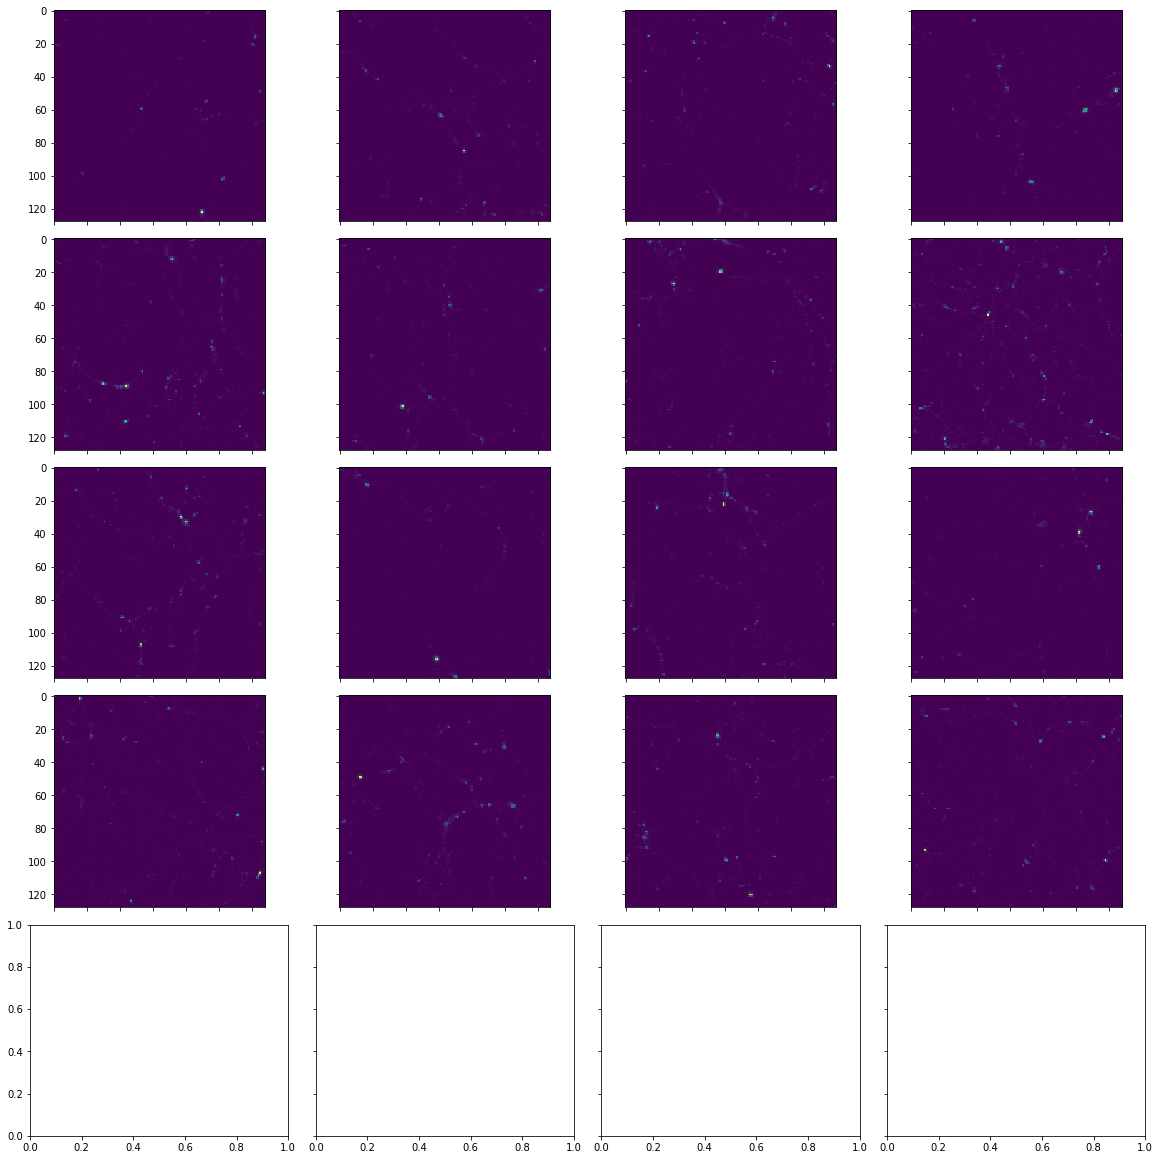

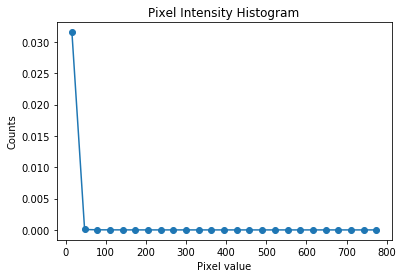

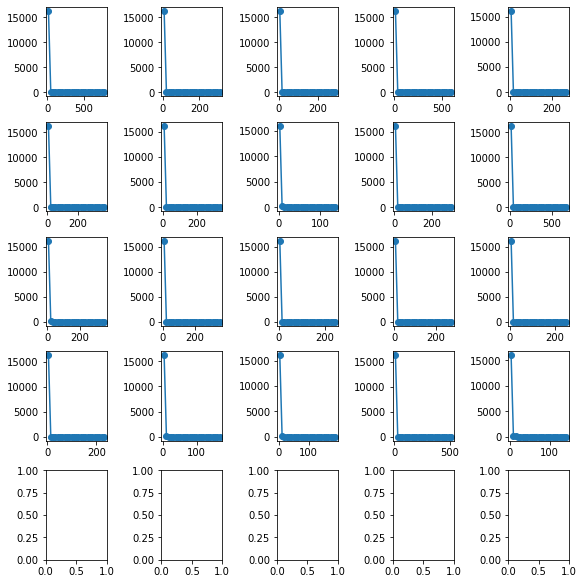

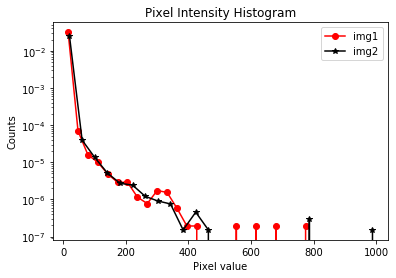

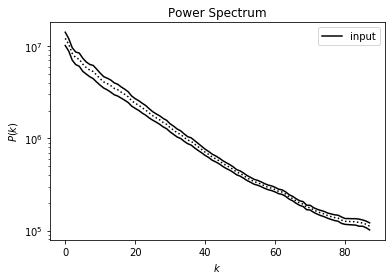

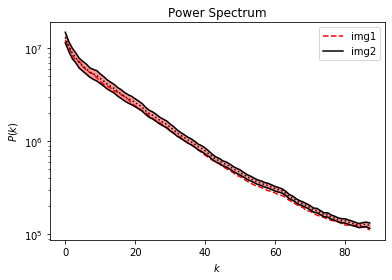

In [5]:
if __name__=='__main__':
    
    data_dir = '/global/project/projectdirs/dasrepo/vpa/cosmogan/data/raw_data/'
    fname='raw_train.npy'
    samples = np.load(data_dir+fname, allow_pickle=True)
    samples = samples.transpose(0,3,1,2)[:,0,:,:]
    print(samples.shape)
    img=samples[20]


    ## Use functions
    f_plot_grid(samples[:16],cols=4)
    f_pixel_intensity(samples[:10])
    f_plot_intensity_grid(samples[:20],cols=5)
    f_compare_pixel_intensity(samples[:10],samples[100:110])
    f_get_azimuthalAverage(img)
    f_get_power_spectrum(img)
    f_compute_spectrum(samples[:100])
    f_compare_spectrum(samples[:100],samples[100:200])
